# 10 인물 모드 문제점 찾기

## 10.1 인물모드 생성

### 10.1.1 사람

In [1]:
#필요모듈 import
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
#이미지 가져오기
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/이주빈.jpeg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(556, 560, 3)


In [3]:
#class 생성
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
#가중치 불러오기
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj48/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
#네트워크에 이미지 입력
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(556, 560, 3) (509, 513, 3) 15


15 사람 잘 나왔음

In [6]:
#각 라벨 의미
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

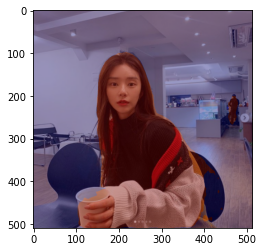

In [7]:
#사람만 검출
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

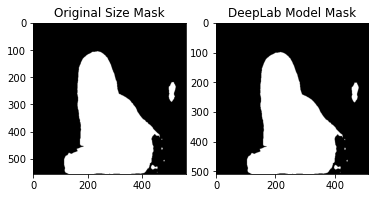

In [8]:
#이미지 크기 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

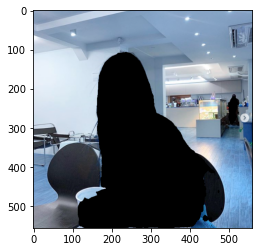

In [9]:
#배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

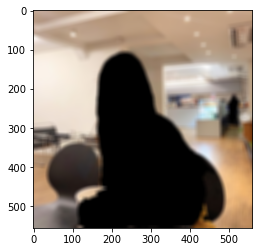

In [10]:
#이미지 블러처리
img_bg_blur = cv2.blur(img_bg, (13,13))#13은 블러 정도
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

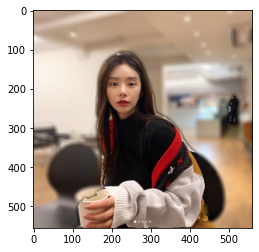

In [11]:
#사람과 배경 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 10.1.2  고양이

In [12]:
#이미지 가져오기
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/고양이.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(536, 750, 3)


In [13]:
#네트워크에 이미지 입력
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(536, 750, 3) (366, 513, 3) 8


8 고양이 잘나왔음

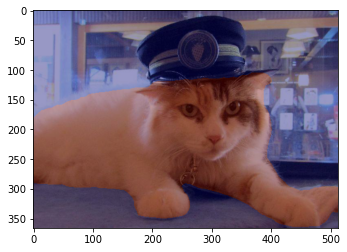

In [14]:
#고양이만 검출
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

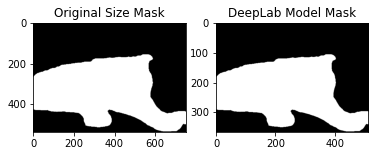

In [15]:
#이미지 크기 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

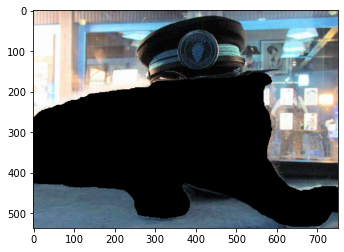

In [16]:
#배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

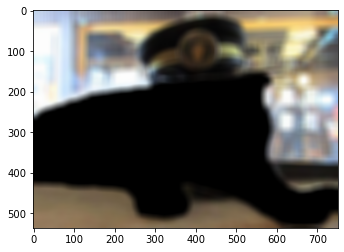

In [17]:
#이미지 블러처리
img_bg_blur = cv2.blur(img_bg, (20,20))#13은 블러 정도
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

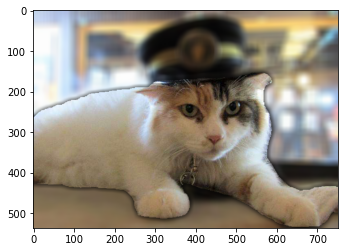

In [18]:
#사람과 배경 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 10.1.3 크로마키

In [19]:
#이미지 가져오기
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/이주빈2.jpg' 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(524, 390, 3)


In [20]:
#네트워크에 이미지 입력
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(524, 390, 3) (513, 381, 3) 15


15 사람 잘나왔음

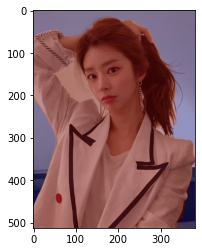

In [21]:
#사람만 검출
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

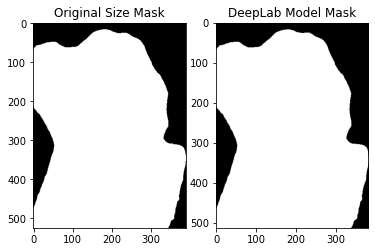

In [22]:
#이미지 크기 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

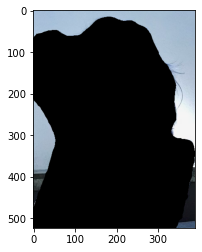

In [23]:
#배경만 추출
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

In [24]:
#배경이미지 가져오기
from PIL import Image
import os
img_path_bag = os.getenv('HOME')+'/aiffel/human_segmentation/images/사무실.jpg' 
img = Image.open(img_path_bag)
img_or = Image.open(img_path)
img_resize = img.resize((int(img_or.width), int(img_or.height)))
img_resize.save(img_path_bag)

img_orig_bag = cv2.imread(img_path_bag) 
print (img_orig_bag.shape)

(524, 390, 3)


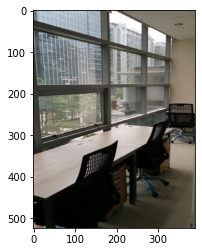

In [25]:
#배경이미지 교체
plt.imshow(cv2.cvtColor(img_orig_bag, cv2.COLOR_BGR2RGB))
plt.show()

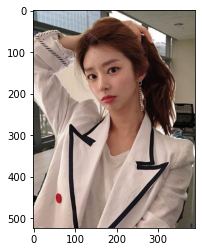

In [26]:
#사람과 배경 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_orig_bag)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

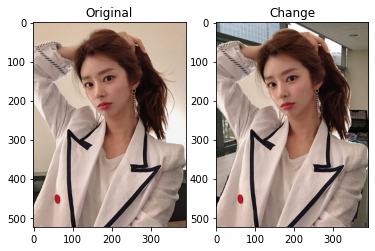

In [27]:
ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
ax.set_title('Original')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax.set_title('Change')
plt.show()

배경 이미지 크기에 비해 인물이 너무 커서 잘 안보이지만 배경 변경되었다.

## 10.2 사진에서 문제점 찾기

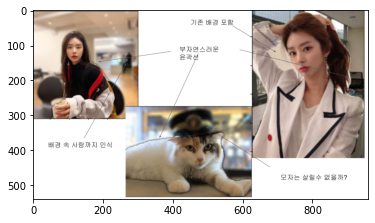

In [28]:
import matplotlib.pyplot as plt
import cairosvg
import numpy as np 
import matplotlib.image as img
import matplotlib.pyplot as pp

### 이미 svg 파일이 있다면, 아래코드만 사용하면 됩니다. 
cairosvg.svg2png(url="/home/aiffel-dj48/aiffel/human_segmentation/images/수정할곳.svg", 
                 write_to="/home/aiffel-dj48/aiffel/human_segmentation/images/수정할곳.png", 
                 dpi = 100
                )




 

modif = "/home/aiffel-dj48/aiffel/human_segmentation/images/수정할곳.png"
ndarray = img.imread(modif)

pp.imshow(ndarray)
pp.show()


## 10.3 해결방안 제시해보기

윤곽선의 불안정함 등은 세그멘틱 모델 학습중 이미지 축소후 진행한다음 축소된 이미지를 복구하는 과정에서 발생하는 손실때문으로 이부분을 보완할 방법을 찾는다면 해결이 가능할것같다.

uDepth

combination of RGB images, people segmentation, and raw depth를 이용한
드롭 아웃방식을 사용하였을때 조금 더 세밀한 형상 분류와  피사체를 제외한 다른 인물들을 
배제할수 있지 않을까 생각해봤다.

# 느낀점
최근 노드들을 진행하면서 초기에 진행하던 모습과 비교하면 그래도 진행에 많은 수월함을 느끼고있다. 하지만 그게 코드 이해도가 높아지기보다는 c, v를 활용하여 작성 속도만 빨라지는 느낌이고 스스로 발전은 더딘것같아 조금 그렇다.
이번 노드를 수행하면서 제시된 요소들을 명확하게 이해하지 못했고 주어진 코드를 활용하여 결과만 도출할수있었다. 조금 더 학구적인 자세가 필요하다 느꼈다.